# Four-Vector Creation Notebook

This notebook creates a list of input parameters to be used for the training of a 1D CNN. We begin by importing our libraries:

In [1]:
import numpy as np
import pandas 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import time
import h5py
import sklearn
from sklearn.utils import shuffle
import os

In [2]:
if not os.path.isdir("data"):
    os.mkdir("data")

In [3]:
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'figure.facecolor':'white'
         }
plt.rc('font', family='serif')
plt.rcParams.update(params)
plt.style.context('default')

We create a partition for distributing $p_{T}$ amongs the particles in each subjet:

In [4]:
def partition_exp(n_particles=10, nevents=1, mu=1.):
    evals = np.random.exponential(scale = mu, size=(nevents,n_particles))
    sumRow =np.repeat(evals.sum(axis=1), n_particles).reshape(nevents, n_particles)
    evals = np.sort(np.divide(evals,sumRow))[:, ::-1]
    return evals

The four-vectors can now be created. Please refer to the literature in this repository for a more detailed overview of these parameters. Note that dtheta and phi correspond to $\delta \alpha$ and $\delta \beta$ respectively.

In [5]:
def makeFourVectors(n_events = 10, n_particles = 5, isSignal = False, overlap = 0):
    labels = np.zeros(shape=(n_events,2))
    
    zloc = 0.5
    theta_loc = 0.2
    
    # Signal jets are sampled from a normal distribution
    if isSignal:
        if (overlap==0):
            theta = np.random.normal(loc=theta_loc, scale=0.02, size=n_events) # signal_d
            z = np.random.normal(loc=zloc, scale=0.02, size=n_events) #signal_z 
        elif(overlap==1):
            theta = np.random.normal(loc=theta_loc, scale=0.03, size=n_events) # signal_d_littleoverlap
            z = np.random.normal(loc=zloc, scale=0.09, size=n_events) #signal_z_littleoverlap
        elif(overlap==2):
            theta = np.random.normal(loc=theta_loc, scale=0.05, size=n_events) # signal_d_overlap
            z = np.random.normal(loc=zloc, scale=0.12, size=n_events) #signal_z_overlap
        pt = np.random.exponential(scale = 1/0.01, size = (n_events, n_particles))
        eta = 1.1*np.random.normal(loc = 0.0, scale = 1.4, size = (n_events,n_particles))
        phi = np.random.uniform(-3.14,3.14,(n_events, n_particles))
        labels[:,1]=1
        
    # Background jets are sampled from an exponential distribution
    else:
        if (overlap==0):
            theta = np.random.exponential(scale=0.02, size=n_events) # bkg_d
            z = np.random.exponential(scale=0.02, size=n_events) #bkg_z
        elif(overlap==1):
            theta = np.random.exponential(scale=0.03, size=n_events) # bkg_d_littleoverlap
            z = np.random.exponential(scale=0.1, size=n_events) #bkg_z_olittleverlap
        elif(overlap==2):
            theta = np.random.exponential(scale=0.05, size=n_events) # bkg_d_overlap
            z = np.random.exponential(scale=0.15, size=n_events) #bkg_z_overlap
        pt = np.random.exponential(scale=1/0.002675, size = (n_events, n_particles))
        eta = 1.008*np.random.normal(loc = 0.001913, scale = 1.811, size = (n_events, n_particles))
        phi = np.random.uniform(-3.14,3.14,size = (n_events, n_particles))
        labels[:,0]=1
    
    # making z to ensure z<1.0
    z = np.where(z<1.0, z, z%1)   
    # making so that z is always more than 1-z
    z = np.where(z>0.5, z, (1-z))
    
    z = np.repeat(z, n_particles).reshape(n_events, n_particles)
    
    # making theta to ensure theta<0.5
    theta = np.where(theta<0.5, theta, theta%0.5)
    theta = np.repeat(theta, n_particles).reshape(n_events, n_particles)
    
    # distributing pT fractions between particles
    particles1 = np.multiply(partition_exp(n_particles, n_events), z)
    particles2 = np.multiply(partition_exp(n_particles, n_events), (1-z))    
    
    # one jet has two subjets; 
    radii = np.random.uniform(0.25,0.5 ,size = (n_events,2))
    radii1 = np.array([np.multiply(np.ones(shape = int(n_particles)),y) for y in radii[:,0]])
    radii2 = np.array([np.multiply(np.ones(shape = int(n_particles)),y) for y in radii[:,1]])
    dtheta1 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles))) # delta theta for first subjet
    dtheta1= np.sort(np.where(dtheta1<radii1, dtheta1, dtheta1%radii1))
    phi1 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles))) # angular
    dtheta2 = np.random.exponential(scale=0.5, size=(n_events, int(n_particles))) # delta theta for second subjet
    dtheta2= np.sort(np.where(dtheta2<radii2, dtheta2, dtheta2%radii2))
    phi2 = np.random.uniform(0, 2*math.pi, size=(n_events, int(n_particles))) # angular
    
    z = z[:,0]
    r1 = radii[:,0]
    r2 = radii[:,1]
    return particles1, particles2, dtheta1, dtheta2, phi1, phi2, r1, r2, z, theta, labels

In [6]:
def plot_variable(sig_hist, bkg_hist, bins, name, feature):
    fig=plt.figure(figsize=(6, 4))
    ax1 = fig.add_subplot()
    ax1.hist(sig_hist.flatten(), density=False,weights = np.ones(len(sig_hist.flatten()))/len(sig_hist.flatten()),
             histtype='step', alpha=0.55, facecolor='#1f77b4', bins=bins, lw=2,
             label='Signal', hatch='/', edgecolor='k', fill=True)
    ax1.hist(bkg_hist.flatten(), density=False, weights = np.ones(len(bkg_hist.flatten()))/len(bkg_hist.flatten()),
            histtype='step',alpha=0.55, facecolor='#ff7f0e', bins=bins, lw=2,
            label='Background', hatch='\\', edgecolor='k', fill=True)
    minx= np.min([np.min(sig_hist.flatten()), np.min(bkg_hist.flatten())])
    maxx= np.max([np.max(sig_hist.flatten()), np.max(bkg_hist.flatten())])
    ax1.set_xlim(minx,maxx)
    ax1.legend(loc='upper center')
    ax1.set_ylabel('Fraction')
    ax1.set_xlabel(name)
    plt.title('Toy Model ' + name + ' Distribution')
    plt.show()

One million events are created for our 20 total particles. Half are signal jets and half are background jets:

In [7]:
n_events = 1000000
n_particles = 10                                             

tic = time.perf_counter()
isSignal1 = True
overlap = 1
pt1_1, pt2_1, dtheta1_1, dtheta2_1, phi1_1, phi2_1, radii1_1, radii2_1, z1, theta1, labels1 = makeFourVectors(n_events, n_particles, isSignal1, overlap)
features1 = [pt1_1, pt2_1, dtheta1_1, dtheta2_1, phi1_1, phi2_1, radii1_1, radii2_1, z1, theta1]
toc = time.perf_counter()
print('Processing Time is ',toc-tic, 'seconds for ',n_events, ' samples.' )

Processing Time is  10.346160769999983 seconds for  1000000  samples.


In [8]:
isSignal2 = False
pt1_2, pt2_2, dtheta1_2, dtheta2_2, phi1_2, phi2_2, radii1_2, radii2_2, z2, theta2, labels2= makeFourVectors(n_events, n_particles, isSignal2, overlap)
features2 = [pt1_2, pt2_2, dtheta1_2, dtheta2_2, phi1_2, phi2_2, radii1_2, radii2_2, z2, theta2, labels2]

isSignal3 = True
pt1_3, pt2_3, dtheta1_3, dtheta2_3, phi1_3, phi2_3, radii1_3, radii2_3, z3, theta3, labels3= makeFourVectors(n_events, n_particles, isSignal3, overlap)
features3 = [pt1_3, pt2_3, dtheta1_3, dtheta2_3, phi1_3, phi2_3, radii1_3, radii2_3, z3, theta3, labels3]

isSignal4 = False
pt1_4, pt2_4, dtheta1_4, dtheta2_4, phi1_4, phi2_4, radii1_4, radii2_4, z4, theta4, labels4= makeFourVectors(n_events, n_particles, isSignal4, overlap)
features4 = [pt1_4, pt2_4, dtheta1_4, dtheta2_4, phi1_4, phi2_4, radii1_4, radii2_4, z4, theta4, labels4]

Some data created in Pythia is now uploaded to be used in our probability distributions:

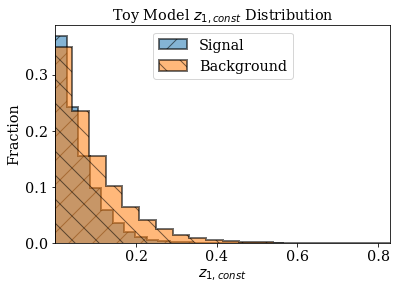

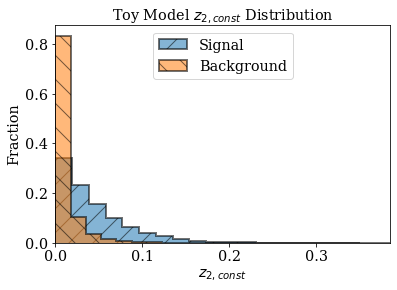

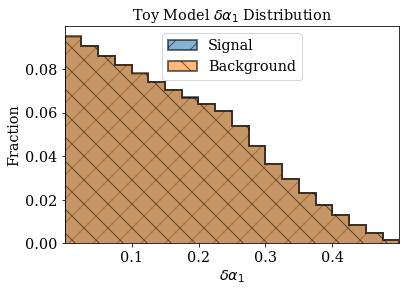

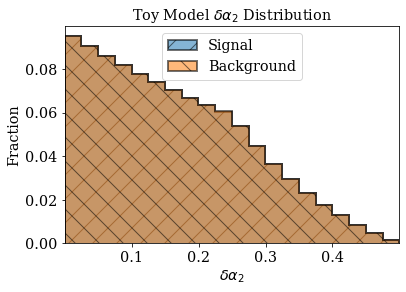

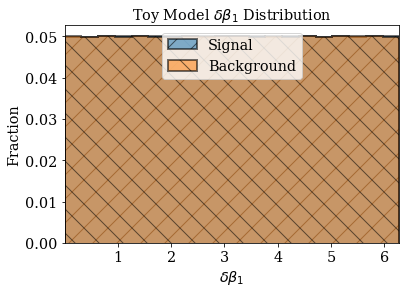

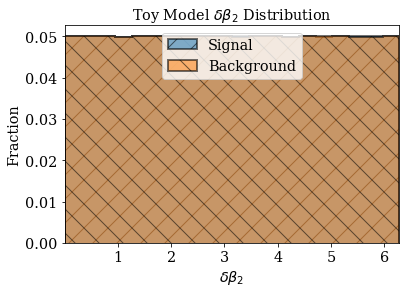

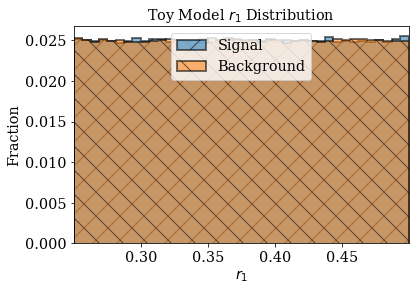

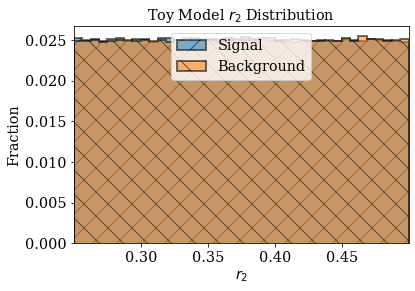

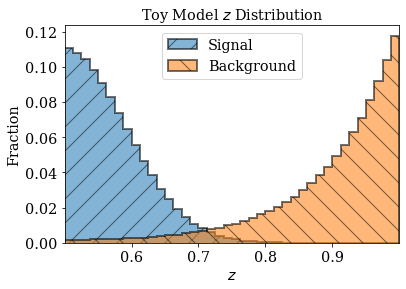

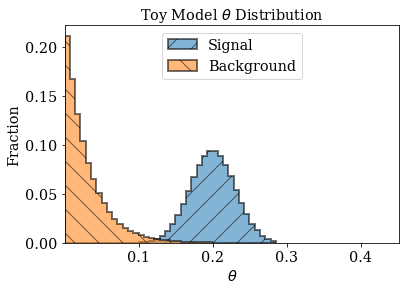

In [9]:
names = [r'$z_{1,const}$', r'$z_{2,const}$', r'$\delta\alpha_1$', r'$\delta\alpha_2$', r'$\delta\beta_1$', r'$\delta\beta_2$', r'$r_1$', r'$r_2$', r'$z$', r'$\theta$' ]
features = ['z1', 'z2', 'a1', 'a2', 'phi1', 'phi2', 'r1', 'r2', 'z', 'theta']
thetabin = [1.11248276e-06, 7.13714472e-03, 1.42731770e-02, 2.14092092e-02,
       2.85452414e-02, 3.56812737e-02, 4.28173059e-02, 4.99533381e-02,
       5.70893704e-02, 6.42254026e-02, 7.13614348e-02, 7.84974671e-02,
       8.56334993e-02, 9.27695316e-02, 9.99055638e-02, 1.07041596e-01,
       1.14177628e-01, 1.21313660e-01, 1.28449693e-01, 1.35585725e-01,
       1.42721757e-01, 1.49857789e-01, 1.56993822e-01, 1.64129854e-01,
       1.71265886e-01, 1.78401918e-01, 1.85537951e-01, 1.92673983e-01,
       1.99810015e-01, 2.06946047e-01, 2.14082080e-01, 2.21218112e-01,
       2.28354144e-01, 2.35490176e-01, 2.42626209e-01, 2.49762241e-01,
       2.56898273e-01, 2.64034305e-01, 2.71170337e-01, 2.78306370e-01,
       2.85442402e-01]
zbin = [0, 0.51250213, 0.52500201, 0.5375019 , 0.55000179,
       0.56250167, 0.57500156, 0.58750145, 0.60000133, 0.61250122,
       0.62500111, 0.63750099, 0.65000088, 0.66250077, 0.67500065,
       0.68750054, 0.70000043, 0.71250031, 0.7250002 , 0.73750009,
       0.74999997, 0.76249986, 0.77499975, 0.78749963, 0.79999952,
       0.81249941, 0.82499929, 0.83749918, 0.84999907, 0.86249895,
       0.87499884, 0.88749873, 0.89999861, 0.9124985 , 0.92499839,
       0.93749827, 0.94999816, 0.96249805, 0.97499793, 0.98749782,
       0.99999771]
rbin = [0.2500161 , 0.25626493, 0.26251377, 0.2687626 , 0.27501144,
       0.28126027, 0.28750911, 0.29375794, 0.30000678, 0.30625561,
       0.31250445, 0.31875328, 0.32500212, 0.33125095, 0.33749979,
       0.34374862, 0.34999746, 0.35624629, 0.36249513, 0.36874396,
       0.3749928 , 0.38124163, 0.38749047, 0.3937393 , 0.39998814,
       0.40623697, 0.41248581, 0.41873464, 0.42498348, 0.43123231,
       0.43748115, 0.44372998, 0.44997882, 0.45622765, 0.46247649,
       0.46872532, 0.47497416, 0.48122299, 0.48747183, 0.49372066,
       0.4999695 ]

bins = [20, 20, 20, 20, 20, 20, rbin, rbin, zbin, thetabin]
for i in np.arange(len(features1)):
    plot_variable(features1[i], features2[i], bins[i], names[i], features[i])

Next, we concatenate the signal and background data to be used for training our network:

In [10]:
trainlabels = np.concatenate((labels1,labels2),axis=0)
n_train = len(trainlabels)
train_pt1 = np.concatenate((pt1_1, pt1_2), axis = 0)
batch = np.size(train_pt1, 1)
train_pt1 = train_pt1.reshape(n_train, batch, 1)
train_pt2 = np.concatenate((pt2_1, pt2_2), axis = 0)
train_pt2 = train_pt2.reshape(n_train, batch, 1)
train_dtheta1 = np.concatenate((dtheta1_1, dtheta1_2), axis = 0).reshape(n_train, batch, 1)
train_dtheta2 = np.concatenate((dtheta2_1, dtheta2_2), axis = 0).reshape(n_train, batch, 1)
train_dphi1 = np.concatenate((phi1_1, phi1_2), axis = 0).reshape(n_train, batch, 1)
train_dphi2 = np.concatenate((phi2_1, phi2_2), axis = 0).reshape(n_train, batch, 1)
train_r1 = np.concatenate((radii1_1, radii1_2), axis = 0)
train_r2 = np.concatenate((radii2_1, radii2_2), axis = 0)
train_theta = np.concatenate((theta1, theta2), axis = 0)
train_z = np.concatenate((z1, z2), axis = 0)
train_labels = trainlabels.reshape(n_train, 2)

The same is done to the data to be used for testing our network:

In [11]:
testlabels = np.concatenate((labels3, labels4),axis=0)
n_test = len(testlabels)
test_pt1 = np.concatenate((pt1_3, pt1_4), axis = 0)
batch = np.size(test_pt1, 1)
test_pt1 = test_pt1.reshape(n_test, batch, 1)
test_pt2 = np.concatenate((pt2_3, pt2_4), axis = 0)
test_pt2 = train_pt2.reshape(n_test, batch, 1)
test_dtheta1 = np.concatenate((dtheta1_3, dtheta1_4), axis = 0).reshape(n_test, batch, 1)
test_dtheta2 = np.concatenate((dtheta2_3, dtheta2_4), axis = 0).reshape(n_test, batch, 1)
test_dphi1 = np.concatenate((phi1_3, phi1_4), axis = 0).reshape(n_test, batch, 1)
test_dphi2 = np.concatenate((phi2_3, phi2_4), axis = 0).reshape(n_test, batch, 1)
test_r1 = np.concatenate((radii1_3, radii1_4), axis = 0)
test_r2 = np.concatenate((radii2_3, radii2_4), axis = 0)
test_theta = np.concatenate((theta3, theta4), axis = 0)
test_z = np.concatenate((z3, z4), axis = 0)
test_labels = testlabels.reshape(n_test, 2)

Lastly, we shuffle each respective data set and save our results: 

In [12]:
train_id = np.random.permutation(len(train_labels))
test_id = np.random.permutation(len(test_labels))
train_pt_id = np.argsort
train_features = [train_pt1, train_pt2, train_dtheta1, train_dtheta2, train_dphi1, train_dphi2, 
                  train_theta, train_r1, train_r2, train_z, train_labels]
test_features = [test_pt1, test_pt2, test_dtheta1, test_dtheta2, test_dphi1, test_dphi2, 
                  test_theta, test_r1, test_r2, test_z, test_labels]
for i in np.arange(len(train_features)):
    train_features[i] = train_features[i][train_id]
    test_features[i] = test_features[i][test_id]

In [13]:
np.savez('data/jetListTrain', pt1 = train_features[0], pt2 = train_features[1], dtheta1 = train_features[2], 
         dtheta2 = train_features[3], dphi1 = train_features[4], dphi2 = train_features[5], theta = train_features[6],
         r1 = train_features[7], r2 = train_features[8], z = train_features[9], labels = train_features[10])
np.savez('data/jetListTest', pt1 = test_features[0], pt2 = test_features[1], dtheta1 = test_features[2], 
         dtheta2 = test_features[3], dphi1 = train_features[4], dphi2 = test_features[5], theta = test_features[6], 
         r1 = test_features[7], r2 = test_features[8], z = test_features[9], labels = test_features[10])